### Initialization Bock

In [1]:
#!pip install tensorflow==1.12.0

In [2]:
# Initialization
colab_run=False
anc_box= False
_grid_offset=True
train=True
data_save=True
if colab_run==True:
  !pip install pydrive
  from pydrive.auth import GoogleAuth
  from pydrive.drive import GoogleDrive
  from google.colab import auth
  from oauth2client.client import GoogleCredentials

  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)

  import os, cv2
  from google.colab import drive
  drive.mount('/content/drive/')

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.layers import concatenate
from tensorflow.keras.callbacks import ModelCheckpoint
from matplotlib import pyplot as plt
import tensorflow.keras.backend as K
import tensorflow as tf
import numpy as np
import pickle
import os, cv2

#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
#os.environ["CUDA_VISIBLE_DEVICES"] = ""

# %matplotlib inline


C:\Users\irfan\Anaconda3\envs\tf\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\irfan\Anaconda3\envs\tf\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\irfan\Anaconda3\envs\tf\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\irfan\Anaconda3\envs\tf\lib\site-packages\tensorflow\python\framework\dty

### Configure Block

### Model Building Block

In [3]:
LABELS=['person', 'bird', 'cat', 'cow', 'dog', 'horse', 'sheep','aeroplane', 'bicycle',
         'boat', 'bus', 'car', 'motorbike', 'train', 'bottle', 'chair','diningtable',
         'pottedplant', 'sofa', 'tvmonitor']

IMAGE_H, IMAGE_W = 416, 416
GRID_H,  GRID_W  = 13 , 13 
BOX              = 5
CLASS            = len(LABELS)
CLASS_WEIGHTS    = np.ones(CLASS, dtype='float32')
OBJ_THRESHOLD    = 0.3#0.5
NMS_THRESHOLD    = 0.3#0.45
#ANCHORS          = [0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828]
ANCHORS          = [ 4.469053,2.148582,10.548851,5.381520,11.420664,9.961033,6.517299,3.699693,2.469196,1.599054]
#ANCHORS=[13,13]
NO_OBJECT_SCALE  = 1.0
OBJECT_SCALE     = 5.0
COORD_SCALE      = 1.0
CLASS_SCALE      = 1.0

BATCH_SIZE       = 10
WARM_UP_BATCHES  = 0
TRUE_BOX_BUFFER  = 50
lambda_coord=5.0
lambda_noobj=0.5

lr=1e-5
epochs=70
optimizer = Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
#optimizer = SGD(lr=1e-4, decay=0.0005, momentum=0.9)
#optimizer = RMSprop(lr=1e-4, rho=0.9, epsilon=1e-08, decay=0.0)
exp_name='v-1.1/'
root='D:/'
path_wts=root+'yolo.weights'
path_wts_final=root+exp_name+'yolo_400_exp2_50.h5'
if not os.path.exists(root+exp_name):
    os.mkdir(root+exp_name)

In [4]:
# the function to implement the orgnization layer (thanks to github.com/allanzelener/YAD2K)
def space_to_depth_x2(x):
    return tf.space_to_depth(x, block_size=2)

def build_model():
  input_image = Input(shape=(IMAGE_H, IMAGE_W, 3))
  true_boxes  = Input(shape=(1, 1, 1, TRUE_BOX_BUFFER , 4))

  # Layer 1
  x = Conv2D(32, (3,3), strides=(1,1), padding='same', name='conv_1', use_bias=False)(input_image)
  x = BatchNormalization(name='norm_1')(x)
  x = LeakyReLU(alpha=0.1)(x)
  x = MaxPooling2D(pool_size=(2, 2))(x)

  # Layer 2
  x = Conv2D(64, (3,3), strides=(1,1), padding='same', name='conv_2', use_bias=False)(x)
  x = BatchNormalization(name='norm_2')(x)
  x = LeakyReLU(alpha=0.1)(x)
  x = MaxPooling2D(pool_size=(2, 2))(x)

  # Layer 3
  x = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_3', use_bias=False)(x)
  x = BatchNormalization(name='norm_3')(x)
  x = LeakyReLU(alpha=0.1)(x)

  # Layer 4
  x = Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_4', use_bias=False)(x)
  x = BatchNormalization(name='norm_4')(x)
  x = LeakyReLU(alpha=0.1)(x)

  # Layer 5
  x = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_5', use_bias=False)(x)
  x = BatchNormalization(name='norm_5')(x)
  x = LeakyReLU(alpha=0.1)(x)
  x = MaxPooling2D(pool_size=(2, 2))(x)

  # Layer 6
  x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_6', use_bias=False)(x)
  x = BatchNormalization(name='norm_6')(x)
  x = LeakyReLU(alpha=0.1)(x)

  # Layer 7
  x = Conv2D(128, (1,1), strides=(1,1), padding='same', name='conv_7', use_bias=False)(x)
  x = BatchNormalization(name='norm_7')(x)
  x = LeakyReLU(alpha=0.1)(x)

  # Layer 8
  x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_8', use_bias=False)(x)
  x = BatchNormalization(name='norm_8')(x)
  x = LeakyReLU(alpha=0.1)(x)
  x = MaxPooling2D(pool_size=(2, 2))(x)

  # Layer 9
  x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_9', use_bias=False)(x)
  x = BatchNormalization(name='norm_9')(x)
  x = LeakyReLU(alpha=0.1)(x)

  # Layer 10
  x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_10', use_bias=False)(x)
  x = BatchNormalization(name='norm_10')(x)
  x = LeakyReLU(alpha=0.1)(x)

  # Layer 11
  x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_11', use_bias=False)(x)
  x = BatchNormalization(name='norm_11')(x)
  x = LeakyReLU(alpha=0.1)(x)

  # Layer 12
  x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_12', use_bias=False)(x)
  x = BatchNormalization(name='norm_12')(x)
  x = LeakyReLU(alpha=0.1)(x)

  # Layer 13
  x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_13', use_bias=False)(x)
  x = BatchNormalization(name='norm_13')(x)
  x = LeakyReLU(alpha=0.1)(x)

  skip_connection = x

  x = MaxPooling2D(pool_size=(2, 2))(x)

  # Layer 14
  x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_14', use_bias=False)(x)
  x = BatchNormalization(name='norm_14')(x)
  x = LeakyReLU(alpha=0.1)(x)

  # Layer 15
  x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_15', use_bias=False)(x)
  x = BatchNormalization(name='norm_15')(x)
  x = LeakyReLU(alpha=0.1)(x)

  # Layer 16
  x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_16', use_bias=False)(x)
  x = BatchNormalization(name='norm_16')(x)
  x = LeakyReLU(alpha=0.1)(x)

  # Layer 17
  x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_17', use_bias=False)(x)
  x = BatchNormalization(name='norm_17')(x)
  x = LeakyReLU(alpha=0.1)(x)

  # Layer 18
  x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_18', use_bias=False)(x)
  x = BatchNormalization(name='norm_18')(x)
  x = LeakyReLU(alpha=0.1)(x)

  # Layer 19
  x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_19', use_bias=False)(x)
  x = BatchNormalization(name='norm_19')(x)
  x = LeakyReLU(alpha=0.1)(x)

  # Layer 20
  x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_20', use_bias=False)(x)
  x = BatchNormalization(name='norm_20')(x)
  x = LeakyReLU(alpha=0.1)(x)

  # Layer 21
  skip_connection = Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_21', use_bias=False)(skip_connection)
  skip_connection = BatchNormalization(name='norm_21')(skip_connection)
  skip_connection = LeakyReLU(alpha=0.1)(skip_connection)
  skip_connection = Lambda(space_to_depth_x2)(skip_connection)

  x = concatenate([skip_connection, x])

  # Layer 22
  x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_22', use_bias=False)(x)
  x = BatchNormalization(name='norm_22')(x)
  x = LeakyReLU(alpha=0.1)(x)

  if anc_box==True:
    # Layer 23
    x = Conv2D(BOX*(4 + 1 + CLASS), (1,1), strides=(1,1), padding='same', name='conv_23')(x)
    output = Reshape((GRID_H, GRID_W,BOX,4 + 1 + CLASS))(x)
  else :
    # Layer 23
    x = Conv2D((4 + 1 + CLASS), (1,1), strides=(1,1), padding='same', name='conv_23')(x)
    output = Reshape((GRID_H, GRID_W,4 + 1 + CLASS))(x)

  # small hack to allow true_boxes to be registered when Keras build the model 
  # for more information: https://github.com/fchollet/keras/issues/2790
  #output = Lambda(lambda args: args[0])([output, true_boxes])#Change :Hasib

  #model = Model([input_image, true_boxes], output)#Change :Hasib
  model = Model(input_image, output)
  return model
  #model.load_weights('/content/drive/My Drive/Data/yolo_net_ep500_act.h5')


class WeightReader:
    def __init__(self, weight_file):
        self.offset = 4
        self.all_weights = np.fromfile(weight_file, dtype='float32')
        
    def read_bytes(self, size):
        self.offset = self.offset + size
        return self.all_weights[self.offset-size:self.offset]
    
    def reset(self):
        self.offset = 4

def load_weights(model,path_wst):
  wt_path = path_wts                      
  weight_reader = WeightReader(wt_path)
  weight_reader.reset()
  nb_conv = 23

  for i in range(1, nb_conv+1):
      conv_layer = model.get_layer('conv_' + str(i))

      if i < nb_conv:
          norm_layer = model.get_layer('norm_' + str(i))

          size = np.prod(norm_layer.get_weights()[0].shape)

          beta  = weight_reader.read_bytes(size)
          gamma = weight_reader.read_bytes(size)
          mean  = weight_reader.read_bytes(size)
          var   = weight_reader.read_bytes(size)

          weights = norm_layer.set_weights([gamma, beta, mean, var])       

      if len(conv_layer.get_weights()) > 1:
          bias   = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
          kernel = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
          kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
          kernel = kernel.transpose([2,3,1,0])
          conv_layer.set_weights([kernel, bias])
      else:
          kernel = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
          kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
          kernel = kernel.transpose([2,3,1,0])
          conv_layer.set_weights([kernel])
  return model



def yolo_loss_1(y_true, y_pred):
      loss=0
          ### adjust w and h
      obj_mask_ex= tf.expand_dims(y_true[..., 4], axis=-1)
      obj_mask= y_true[..., 4]
      #conf_obj_mask=y_true[...,4]
      noobj_mask=np.abs(y_true[...,4]-1)
      
      if anc_box==True:
        _x = tf.to_float(tf.reshape(tf.tile(tf.range(GRID_W), [GRID_H]), (1, GRID_H, GRID_W, 1, 1)))#1,13,13,1,1
        _y = tf.transpose(_x, (0,2,1,3,4))#1,13,13,1,1
        _grid = tf.tile(tf.concat([_x,_y], -1), [BATCH_SIZE, 1, 1, 5, 1])#10,13,13,5,1

        pred_xy = tf.sigmoid(y_pred[..., :2]) + cell_grid
        pred_wh = tf.exp(y_pred[..., 2:4]) * np.reshape(ANCHORS, [1,1,1,BOX,2])
        
      if anc_box==False and _grid_offset==True:
        _x = tf.to_float(tf.reshape(tf.tile(tf.range(GRID_W), [GRID_H]), (1, GRID_H, GRID_W, 1)))#1,13,13,1,1
        _y = tf.transpose(_x, (0,2,1,3))#1,13,13,1
        _grid = tf.tile(tf.concat([_x,_y], -1), [BATCH_SIZE, 1, 1, 1])#10,13,13,1

        pred_xy = tf.sigmoid(y_pred[..., :2]) + _grid
        pred_wh = y_pred[..., 2:4]# * np.reshape(ANCHORS, [1,1,1,BOX,2])
        #pred_wh = tf.exp(y_pred[..., 2:4]) * np.reshape(ANCHORS, [1,1,1,BOX,2])
      
      if _grid_offset==False:
        pred_xy=y_pred[...,0:2] #+ cell_grid # if cell_grid Batch_Gen center_x -=grid_x
        pred_wh=y_pred[...,2:4]
      

      true_xy=y_true[...,0:2]
      true_wh=y_true[...,2:4]
      pred_conf=y_pred[...,4]
      ### adjust confidence
      true_wh_half = true_wh / 2.
      true_mins    = tf.subtract(true_xy,true_wh_half)
      true_maxes   = tf.add(true_xy,true_wh_half)
    
      pred_wh_half = pred_wh / 2.
      pred_mins    = tf.subtract(pred_xy,pred_wh_half)
      pred_maxes   = tf.add(pred_xy,pred_wh_half)       
    
      intersect_mins  = tf.maximum(pred_mins,  true_mins)
      intersect_maxes = tf.minimum(pred_maxes, true_maxes)
      intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
      intersect_areas = tf.multiply(intersect_wh[..., 0] , intersect_wh[..., 1])
    
      true_areas = tf.multiply(true_wh[..., 0] , true_wh[..., 1])
      pred_areas = tf.multiply(pred_wh[..., 0] , pred_wh[..., 1])

      union_areas =tf.subtract(tf.add(pred_areas,true_areas),intersect_areas)
      intersect_areas=tf.add(intersect_areas,1)
      union_areas=tf.add(union_areas,1)
      iou_scores  = tf.truediv(intersect_areas, union_areas)
      true_box_class = tf.argmax(y_true[..., 5:], -1)
      pred_box_class=y_pred[..., 4]
      pred_box_class = y_pred[..., 5:]
      class_mask = y_true[..., 4] * tf.gather(CLASS_WEIGHTS, true_box_class)
    
      #class_mask = y_true[..., 4] * tf.to_float(true_box_class)
      nb_class_box = tf.reduce_sum(tf.to_float(class_mask > 0.0))
      true_conf =tf.multiply( iou_scores,y_true[..., 4])
      
      loss_bb=tf.subtract(true_xy,pred_xy)
      loss_bb=tf.square(loss_bb)
      loss_bb=tf.multiply(loss_bb,obj_mask_ex)
      loss_bb=tf.reduce_sum(loss_bb)
    
      pred_wh_abs=tf.abs(pred_wh)
      pred_wh_sign=tf.truediv(pred_wh,pred_wh_abs)
      loss_wh=tf.subtract(tf.sqrt(true_wh),tf.multiply(pred_wh_sign,tf.sqrt(pred_wh_abs)))
      loss_wh=tf.square(loss_wh)
      loss_wh=tf.multiply(loss_wh,obj_mask_ex)
      loss_wh=tf.reduce_sum(loss_wh)
    
      loss_conf=tf.subtract(true_conf,pred_conf)
      loss_conf=tf.square(loss_conf)
      loss_conf=tf.multiply(loss_conf,obj_mask)
      loss_conf=tf.reduce_sum(loss_conf)
    
      loss_noobj_conf=tf.subtract(true_conf,pred_conf)
      loss_noobj_conf=tf.square(loss_noobj_conf)
      loss_noobj_conf=tf.multiply(loss_noobj_conf,noobj_mask)
      loss_noobj_conf=tf.reduce_sum(loss_noobj_conf)
    
      loss_class = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=true_box_class, logits=pred_box_class)
      loss_class = tf.reduce_sum(loss_class * class_mask) / (nb_class_box + 1e-6)
      loss=lambda_coord*loss_bb+lambda_coord*loss_wh+loss_conf+lambda_noobj*loss_noobj_conf+loss_class       
      return loss


### Data Ready Block

In [5]:
if colab_run==True :data_dir='/content/drive/My Drive/CNN_Basic/'
else: data_dir=''
from xml.etree import ElementTree as ET

def read_content(xml_file,_dir):
    objs=[]
    tree = ET.parse(xml_file)
    root = tree.getroot()

    list_with_all_boxes = []
    filename = root.find('filename').text
    size=root.find('size')
    img_h=int(size.find('height').text)
    img_w=int(size.find('width').text)
    for boxes in root.iter('object'):
        
        name = boxes.find('name').text
        ymin, xmin, ymax, xmax = None, None, None, None
        
        for box in boxes.findall("bndbox"):
            ymin = int(box.find("ymin").text)
            xmin = int(box.find("xmin").text)
            ymax = int(box.find("ymax").text)
            xmax = int(box.find("xmax").text)
        wf=IMAGE_W/img_w
        hf=IMAGE_H/img_h
        obj={'name':name,
          'xmin':xmin*wf,
          'ymin':ymin*hf,
          'xmax':xmax*wf,
          'ymax':ymax*hf}
        objs.append(obj)
        
    out={
          'filename':_dir+'JPEGImages/'+filename,
          'height':img_h,
          'width':img_w,
          'object':objs
    }
        
    return filename, list_with_all_boxes,out

def IOU(bboxes1, bboxes2):
        #import pdb;pdb.set_trace()
        x1_min, y1_min, x1_max, y1_max = list(bboxes1)
        x2_min, y2_min, x2_max, y2_max = list(bboxes2)
        xA = np.maximum(x1_min, x2_min)
        yA = np.maximum(y1_min, y2_min)
        xB = np.minimum(x1_max, x2_max)
        yB = np.minimum(y1_max, y2_max)
        interArea = np.maximum((xB - xA ), 0) * np.maximum((yB - yA ), 0)
        boxAArea = (x1_max - x1_min ) * (y1_max - y1_min )
        boxBArea = (x2_max - x2_min ) * (y2_max - y2_min )
        iou = interArea / (boxAArea + boxBArea - interArea)
        return iou
    
def Batch_Gen(all_data,no_of_batch):
      while(True):
            N=len(all_data)
            _batch_size=N//no_of_batch

            for _ind in range(no_of_batch):

                batch=all_data[_ind*_batch_size:(_ind+1)*_batch_size]
                n=len(batch)
                x_batch = np.zeros((n,IMAGE_H, IMAGE_W,3),dtype=np.float32)                         # input images
                if anc_box==True:
                  y_batch = np.zeros((n, GRID_H, GRID_W,BOX,4+1+len(LABELS)),dtype=np.float)                # desired network output
                else :
                  y_batch = np.zeros((n, GRID_H, GRID_W,4+1+len(LABELS)),dtype=np.float)                # desired network output
                instance_count=0

                
                for sample in batch:

                        image_name = sample['filename']
                        img = cv2.imread(image_name)
                        img = cv2.resize(img, (IMAGE_H,IMAGE_W))
                        img = img[:,:,::-1]
                        img_w=sample['height']
                        img_h=sample['width']
                        all_objs = sample['object']
                        # construct output from object's x, y, w, h
                        true_box_index = 0
                        anchors = [[0, 0, ANCHORS[2*i], ANCHORS[2*i+1]] for i in range(int(len(ANCHORS)//2))]
                        for obj in all_objs:
                            no_gridx=float(IMAGE_W / GRID_W)
                            no_gridy=float(IMAGE_H /GRID_H)
                            if obj['xmax'] > obj['xmin'] and obj['ymax'] > obj['ymin'] and obj['name'] in LABELS:
                                center_x = .5*(obj['xmin'] + obj['xmax'])
                                center_x = center_x/no_gridx
                                center_y = .5*(obj['ymin'] + obj['ymax'])
                                center_y=center_y/no_gridy
                                grid_x = int(np.floor(center_x))
                                grid_y = int(np.floor(center_y))
                                if _grid_offset==False:
                                            center_x-=grid_x
                                            center_y-=grid_y
                                #center_x-=grid_x
                                #center_y-=grid_y
                                if grid_x < GRID_W and grid_y < GRID_H:
                                    obj_indx  = LABELS.index(obj['name'])
                                    center_w = (obj['xmax'] - obj['xmin'])/no_gridx #/ (float(self.config['IMAGE_W'])# / self.config['GRID_W']) # unit: grid cell
                                    center_h = (obj['ymax'] - obj['ymin'])/no_gridy #/ (float(self.config['IMAGE_H'])# / self.config['GRID_H']) # unit: grid cell
                                    center_w=center_w
                                    center_h=center_h

                                    box = [center_x, center_y, center_w, center_h]

                                    # find the anchor that best predicts this box#Change :Hasib
                                    best_anchor = -1
                                    max_iou     = -1

                                    shifted_box = [0, 0, center_w, center_h]

                                    for i in range(len(anchors)):
                                        anchor = anchors[i]
                                        iou    = IOU(shifted_box, anchor)

                                        if max_iou < iou:
                                            best_anchor = i
                                            max_iou     = iou

                                    # assign ground truth x, y, w, h, confidence and class probs to y_batch
                                    if anc_box==True:
                                      y_batch[instance_count, grid_y, grid_x, best_anchor,0:4] = box
                                      y_batch[instance_count, grid_y, grid_x, best_anchor,4  ] = 1.
                                      y_batch[instance_count, grid_y, grid_x, best_anchor,5+obj_indx] = 1
                                    else :
                                      y_batch[instance_count, grid_y, grid_x,0:4] = box
                                      y_batch[instance_count, grid_y, grid_x,4  ] = 1.
                                      y_batch[instance_count, grid_y, grid_x,5+obj_indx] = 1

                                    # assign the true box to b_batch
                                    #b_batch[instance_count, 0, 0, 0, true_box_index] = box#Change: Hasib

                                    #true_box_index += 1
                                    #true_box_index = true_box_index % self.config['TRUE_BOX_BUFFER']

                        # assign input image to x_batch
                        x_batch[instance_count] = img/255

                        # increase instance counter in current batch
                        instance_count += 1  

                        #print(' new batch created', idx)
                yield (x_batch, y_batch)




### Reading Data

In [6]:
import glob
import cv2
import pandas as pd
import pickle


if data_save==True:
  fnames=[]
  
  train_dir='VOC2007/'
  test_dir='VOC2007_test/'
  train_data=[]
  test_data=[]
  i=0
    
  for file in glob.glob(train_dir+'Annotations/*'):
    i+=1
    
    _,_,obj=read_content(file,train_dir)
    train_data.append(obj)

  i=0
  for file in glob.glob(test_dir+'Annotations/*'):
    i+=1
    
    _,_,obj=read_content(file,test_dir)
    test_data.append(obj)
    
  f=open(train_dir+'_VOC_dfs','wb')
  pickle.dump(train_data,f)
  f.close()
  f=open(test_dir+'_VOC_dfs','wb')
  pickle.dump(test_data,f)
  f.close()

f=open(train_dir+'_VOC_dfs','rb')
train_data=pickle.load(f)
f.close()
f=open(test_dir+'_VOC_dfs','rb')
test_data=pickle.load(f)
f.close()

In [7]:
import numpy as np



if train==True or train==False:
  
  #train_imgs=all_data[:n_train]
  valid_data=test_data[:1500]
  N=len(train_data)
  n_train=len(train_data)
  n_valid=len(valid_data)
  train_batch=[]
  valid_batch=[]
  no_of_tr_batch=int(np.floor(n_train/BATCH_SIZE))
  train_batch=Batch_Gen(train_data,no_of_tr_batch)
  no_of_val_batch=int(np.floor(n_valid/BATCH_SIZE))
  valid_batch=Batch_Gen(valid_data,no_of_val_batch)

In [8]:
test_data[0]['filename']

'VOC2007_test/JPEGImages/000001.jpg'

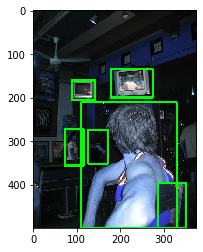

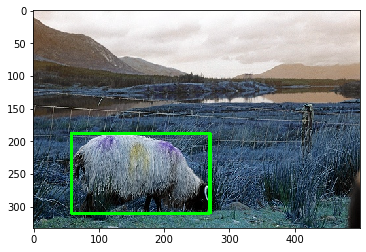

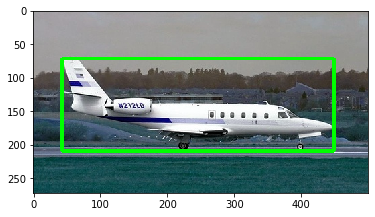

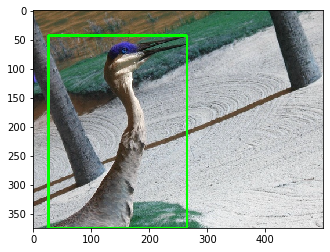

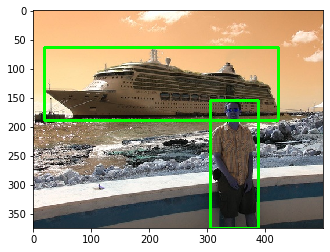

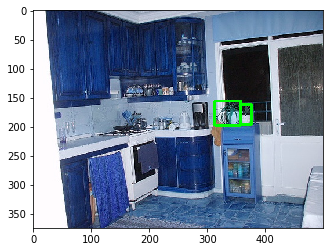

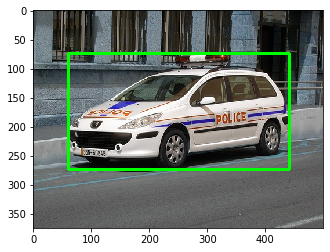

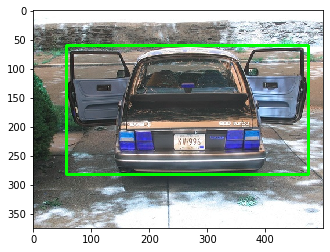

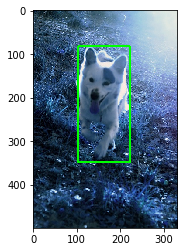

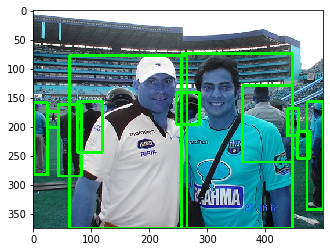

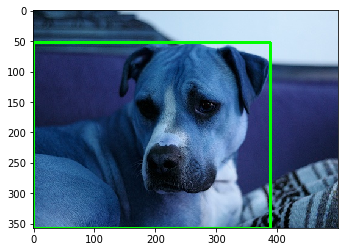

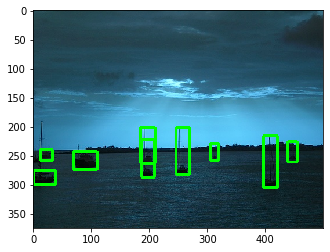

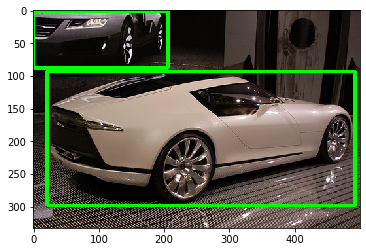

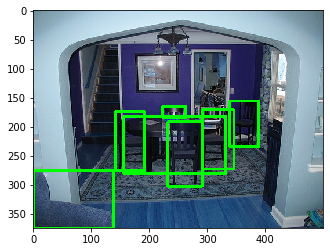

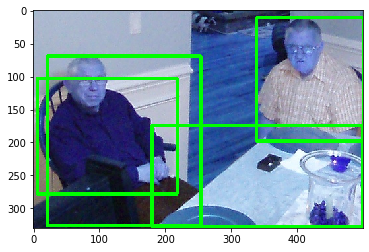

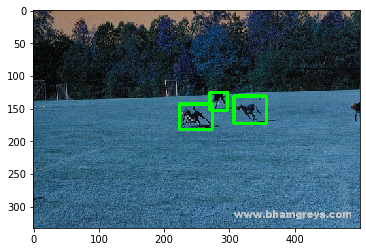

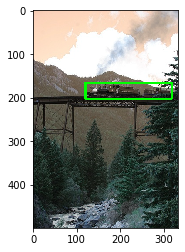

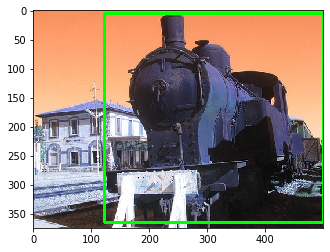

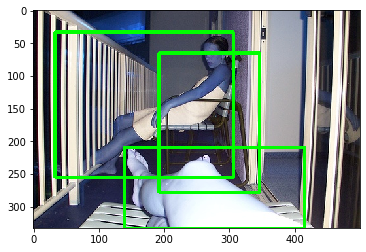

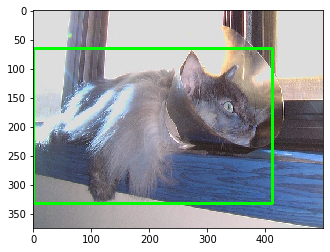

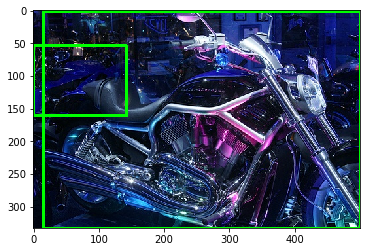

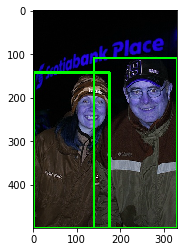

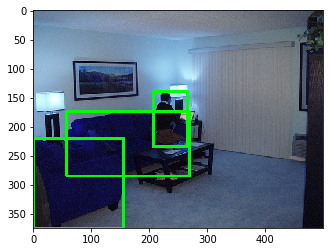

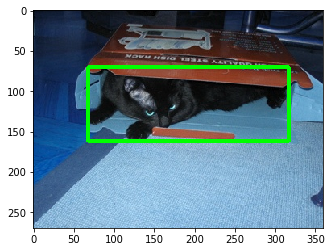

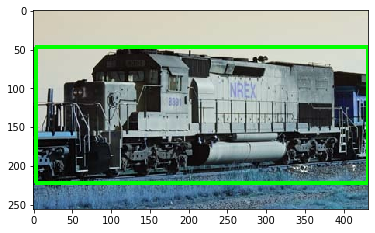

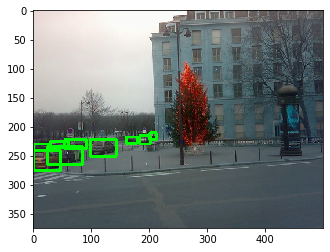

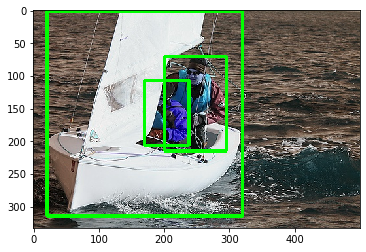

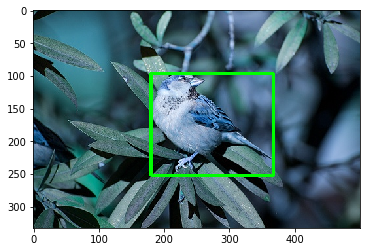

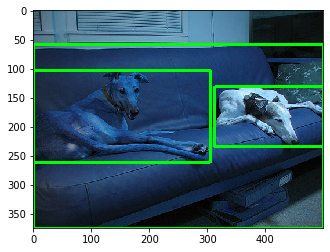

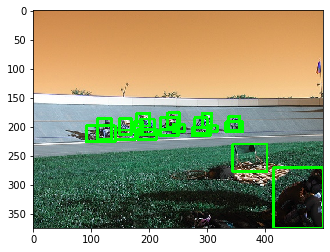

In [9]:
for i in range(30,60):
    image_h=(test_data[i]['height']/416)
    image_w=(test_data[i]['width']/416)
    img=cv2.imread(test_data[i]['filename'])
    for obj in test_data[i]['object']:
        xmin,ymin,xmax,ymax=list(obj.values())[1:]
        cv2.rectangle(img, (int(xmin*image_w),int(ymin*image_h)), (int(xmax*image_w),int(ymax*image_h)), (0,255,0), 3)
    plt.imshow(img)
    plt.show()

In [10]:
image_h=(test_data[i]['height']/416)
test_data[i]['height']/416

0.9014423076923077

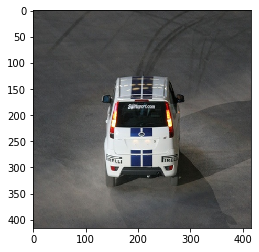

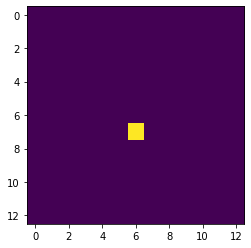

index 4


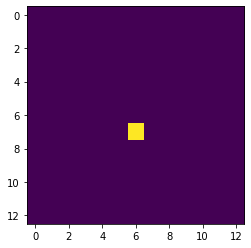

In [11]:
data_check=True
if data_check==True:
    sampleX,sampleY=next(train_batch)
    plt.imshow(sampleX[3])
    plt.show()
    img=sampleY[3][...,11+5]
    plt.imshow(img)
    plt.show()
    for i in range(4,5):
        print('index',i)
        plt.imshow(sampleY[3][...,i]*10)
        plt.show()

### Train Block

In [12]:
model=build_model()
#model.summary()

In [13]:


def train_model(model):
  #filepath="D:/"+exp_name+"weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5"
  filepath=root+exp_name+".hdf5"
  checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
  callbacks_list = [checkpoint]
  model.compile(loss=yolo_loss_1, optimizer=optimizer,metrics=['accuracy'])
  if anc_box==True:
    model.compile(loss=custom_loss, optimizer=optimizer,metrics=['accuracy'])
  history=model.fit_generator(train_batch,
                              steps_per_epoch=no_of_tr_batch,
                              epochs=epochs,
                              callbacks=callbacks_list,
                              validation_data=valid_batch,
                              validation_steps=no_of_val_batch)

  
  return model,history


Epoch 1/70
500/501 [============================>.] - ETA: 0s - loss: 16565.0635 - acc: 0.0679
Epoch 00001: val_loss improved from inf to 5117.29878, saving model to D:/v-1.1/.hdf5
501/501 [==============================] - 294s 587ms/step - loss: 16542.1751 - acc: 0.0679 - val_loss: 5117.2988 - val_acc: 0.0772
Epoch 2/70
500/501 [============================>.] - ETA: 0s - loss: 2173.4383 - acc: 0.0598
Epoch 00002: val_loss improved from 5117.29878 to 910.04537, saving model to D:/v-1.1/.hdf5
501/501 [==============================] - 283s 564ms/step - loss: 2170.9838 - acc: 0.0598 - val_loss: 910.0454 - val_acc: 0.0672
Epoch 3/70
500/501 [============================>.] - ETA: 0s - loss: 608.9603 - acc: 0.0569
Epoch 00003: val_loss improved from 910.04537 to 438.27552, saving model to D:/v-1.1/.hdf5
501/501 [==============================] - 283s 565ms/step - loss: 608.5866 - acc: 0.0569 - val_loss: 438.2755 - val_acc: 0.0673
Epoch 4/70
500/501 [============================>.] - ETA:

501/501 [==============================] - 88s 175ms/step - loss: 35.3789 - acc: 0.0140 - val_loss: 72.6964 - val_acc: 0.0181
Epoch 28/70
500/501 [============================>.] - ETA: 0s - loss: 33.5716 - acc: 0.0139
Epoch 00028: val_loss improved from 72.69639 to 71.48726, saving model to D:/v-1.1/.hdf5
501/501 [==============================] - 88s 175ms/step - loss: 33.5709 - acc: 0.0139 - val_loss: 71.4873 - val_acc: 0.0177
Epoch 29/70
500/501 [============================>.] - ETA: 0s - loss: 31.8880 - acc: 0.0137
Epoch 00029: val_loss improved from 71.48726 to 70.45153, saving model to D:/v-1.1/.hdf5
501/501 [==============================] - 88s 176ms/step - loss: 31.8879 - acc: 0.0137 - val_loss: 70.4515 - val_acc: 0.0172
Epoch 30/70
500/501 [============================>.] - ETA: 0s - loss: 30.3110 - acc: 0.0136
Epoch 00030: val_loss improved from 70.45153 to 69.58088, saving model to D:/v-1.1/.hdf5
501/501 [==============================] - 90s 179ms/step - loss: 30.3114 - 

Epoch 56/70
500/501 [============================>.] - ETA: 0s - loss: 11.5261 - acc: 0.0141
Epoch 00056: val_loss improved from 66.06333 to 65.55951, saving model to D:/v-1.1/.hdf5
501/501 [==============================] - 83s 165ms/step - loss: 11.5261 - acc: 0.0142 - val_loss: 65.5595 - val_acc: 0.0194
Epoch 57/70
500/501 [============================>.] - ETA: 0s - loss: 11.5635 - acc: 0.0141
Epoch 00057: val_loss did not improve from 65.55951
501/501 [==============================] - 82s 164ms/step - loss: 11.5648 - acc: 0.0141 - val_loss: 67.3427 - val_acc: 0.0210
Epoch 58/70
500/501 [============================>.] - ETA: 0s - loss: 11.3102 - acc: 0.0141
Epoch 00058: val_loss did not improve from 65.55951
501/501 [==============================] - 82s 164ms/step - loss: 11.3127 - acc: 0.0141 - val_loss: 65.8213 - val_acc: 0.0219
Epoch 59/70
500/501 [============================>.] - ETA: 0s - loss: 11.9160 - acc: 0.0141
Epoch 00059: val_loss did not improve from 65.55951
501/5

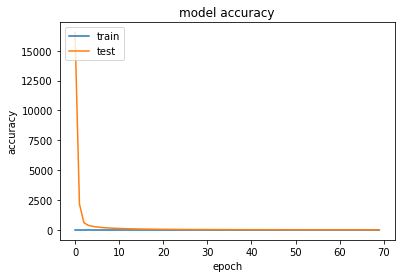

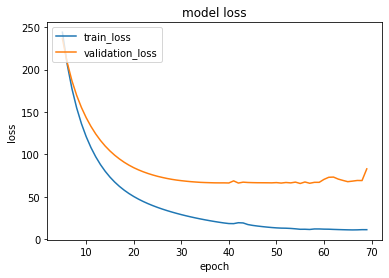

55 [5117.29878255  910.0453658   438.27552104  331.76737834  274.72251495
  236.41485301  208.42788839  186.78255376  169.44336589  155.22222794
  143.18944606  132.90917343  124.0278275   116.34596675  109.68547195
  103.9193675    98.88119629   94.46707316   90.55669655   87.15987053
   84.18475978   81.60914144   79.34531459   77.34776731   75.59871824
   74.02475591   72.69639455   71.48726079   70.45152603   69.58087849
   68.87510909   68.26143225   67.71448143   67.29090164   66.89934959
   66.66595009   66.48686762   66.32728621   66.27778241   66.29565722
   66.16144212   68.65889832   66.0697       67.1250257    66.73656671
   66.564268     66.44961648   66.42544876   66.39278748   66.31629491
   66.5997121    66.06332943   66.72813992   66.2681841    67.18585623
   65.55951153   67.34273588   65.82126202   66.93038203   66.93402472
   70.39538261   72.86368589   73.12436885   70.75099517   69.15735138
   67.69801164   68.35990079   69.11207553   69.01609896   82.81218244]


In [14]:
if train==True:
    model=load_weights(model,path_wts)
    for layer in model.layers[:-5]:
        layer.trainable=False
    model,history=train_model(model)
    
    
    plt.plot(history.history['acc'])
    plt.plot(history.history['loss'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    # summarize history for loss
    plt.plot(range(5,epochs),history.history['loss'][5:])
    plt.plot(range(5,epochs),history.history['val_loss'][5:])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='upper left')
    plt.savefig(root+exp_name+'yolo-v1_exp.png')
    plt.show()
    

    f=open(root+exp_name+'history:_ep_70_v-1.0_exp','wb')
    pickle.dump([history.history['loss'],history.history['val_loss']],f)
    f.close()
    val_loss=np.array(history.history['val_loss'])
    best_epoch=np.argmin(val_loss) 
    print(best_epoch,val_loss)
if train==False:
    model.load_weights(path_wts_final)

### Predicion Block

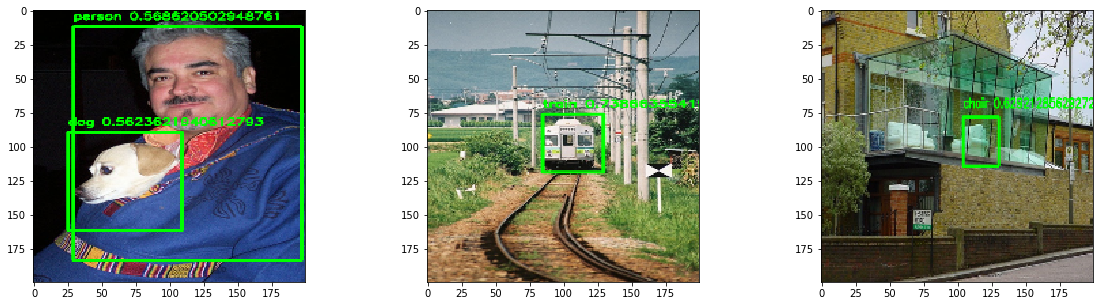

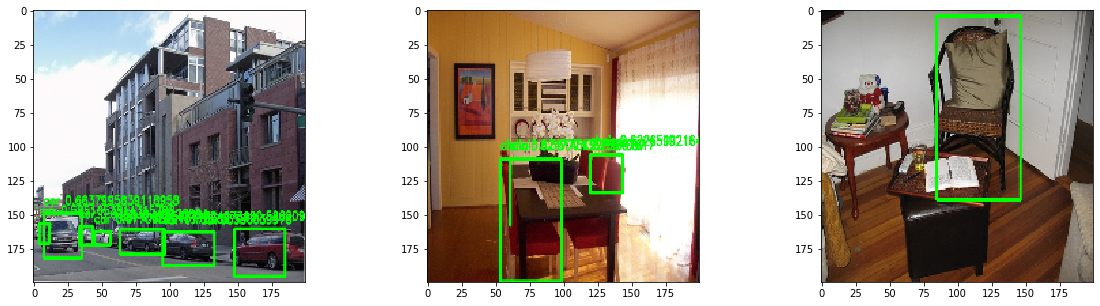

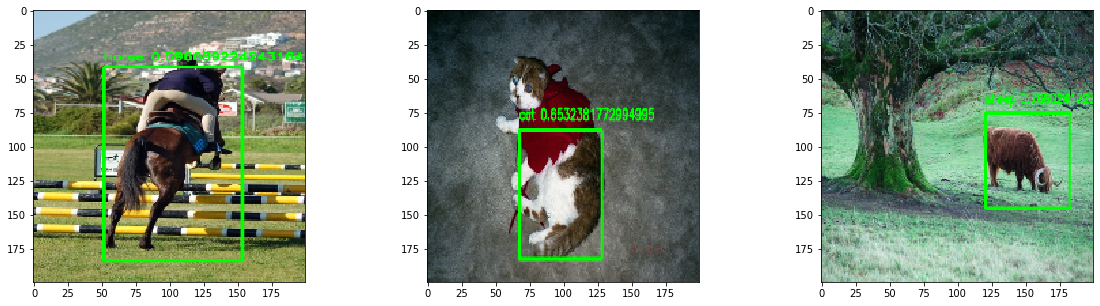

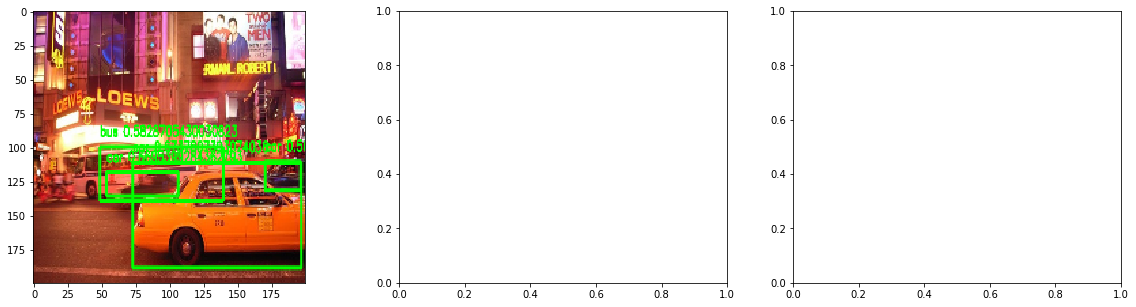

In [16]:
def _softmax(x, axis=-1, t=-100.):
    x = x - np.max(x)
    
    if np.min(x) < t:
        x = x/np.min(x)*t
        
    e_x = np.exp(x)
    
    return e_x / e_x.sum(axis, keepdims=True)

def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

def nmax_supp(boxes):
    df=pd.DataFrame(boxes,columns=['x','y','w','h','conf','_class'])
    sdf=df.sort_values('conf',ascending=False).reset_index(drop=True)
    #print(sdf)
    for ind1 in range(len(sdf)-1):
        box1=sdf.loc[ind1,['x','y','w','h']].values
        b1_class=sdf.loc[ind1,['_class']].values
        for ind2 in range(ind1+1,len(sdf)):
             box2=sdf.loc[ind2,['x','y','w','h']].values
             b2_class=sdf.loc[ind2,['_class']].values
             if b1_class==b2_class and IOU(box1,box2)>=0.1:
                sdf.loc[ind2,'conf']=0.0
    ndf=sdf[sdf.conf>0.0]
    return list(ndf.values)#[:len(ndf.values)//2]

def decode_netout_anc(netout, anchors, nb_class, obj_threshold=0.3, nms_threshold=0.3):
    #grid_h, grid_w, nb_box = netout.shape[:3]
    grid_h, grid_w = netout.shape[:2]

    boxes = []
    
    # decode the output by the network
    netout[..., 4]  = _sigmoid(netout[..., 4])
    netout[..., 5:] = netout[..., 4][..., np.newaxis] * _softmax(netout[..., 5:])
    netout[..., 5:] *= netout[..., 5:] > obj_threshold
    
    for row in range(grid_h):
        for col in range(grid_w):
            for b in range(BOX):
                # from 4th element onwards are confidence and class classes
                classes = netout[row,col,b,5:]
                #classes = netout[row,col,5:]
                confidence = netout[row,col,b,4]
                if np.sum(classes) > 0:
                    # first 4 elements are x, y, w, and h
                    #x, y, w, h = netout[row,col,b,:4]
                    x, y, w, h = netout[row,col,b,:4]
                    #print(col,_sigmoid(x-col),row,_sigmoid(y),w,h)
                    x = (col + _sigmoid(x)) / grid_w # center position, unit: image width
                    y = (row + _sigmoid(y)) / grid_h # center position, unit: image height
                    w = ANCHORS[2 * b + 0] * np.exp(w) / grid_w # unit: image width
                    h = ANCHORS[2 * b + 1] * np.exp(h) / grid_h # unit: image height
                    #print(x,y,w,h)
                    classes=np.argmax(classes)
                    
                    box = (x-w/2, y-h/2, x+w/2, y+h/2, confidence, classes)
                    box = (x-w/2, y-h/2, x+w/2, y+h/2, confidence, classes)
                    if abs(box[0])<=1 and abs(box[1])<=1 and box[2]<=1 and box[3]<=1 :
                      if (box[0])>=0 and (box[1])>=0 and box[2]>=0 and box[3]>=0 :
                        boxes.append(box)
                    

                      
    indx=np.argsort([box[4] for box in boxes])
    f_boxes=[]
    #indx=reversed(indx)
    if len(indx)>=3:
      for i in range(1,2):
        ind=indx[-1*i]
        f_boxes.append(boxes[ind])
    else:
      f_boxes=boxes
    return f_boxes    
    
def decode_netout_1(netout, anchors, nb_class, obj_threshold=0.3, nms_threshold=0.3):
    #grid_h, grid_w, nb_box = netout.shape[:3]
    grid_h, grid_w = netout.shape[:2]

    boxes = []
    
    # decode the output by the network
    netout[..., 4]  = _sigmoid(netout[..., 4])
    netout[..., 5:] = netout[..., 4][..., np.newaxis] * _softmax(netout[..., 5:])
    netout[..., 5:] *= netout[..., 5:] > obj_threshold
    class_prob_log=[0]*CLASS
    #boxes=[(0,)*6]*CLASS
    boxes=[]
    for row in range(grid_h):
        for col in range(grid_w):
            #for b in range(BOX):
                # from 4th element onwards are confidence and class classes
                classes = netout[row,col,5:]
                #classes = netout[row,col,5:]
                confidence = netout[row,col,4]
                if np.sum(classes) > 0:
                    # first 4 elements are x, y, w, and h
                    #x, y, w, h = netout[row,col,b,:4]
                    x, y, w, h = netout[row,col,:4]
                    #print(col,_sigmoid(x-col),row,_sigmoid(y),w,h)
                    w_ratio=(IMAGE_W/GRID_W)/IMAGE_W
                    h_ratio=(IMAGE_W/GRID_W)/IMAGE_H
                    x = (col+_sigmoid(x))*(h_ratio)#x*(32/416) # center position, unit: image width
                    y = (row+_sigmoid(y))*(w_ratio)#y*(32/416) # center position, unit: image height
                    w = w*(w_ratio) # unit: image width
                    h = h*(h_ratio) # unit: image height
                    #print(x,y,w,h)
                    class_ind=np.argmax(classes)
                    #if class_prob_log[class_ind]< classes[class_ind]:       
                    class_prob_log[class_ind]=classes[class_ind]
                    box = (x-w/2, y-h/2, x+w/2, y+h/2, confidence, class_ind)
                    if abs(box[0])<=1 and abs(box[1])<=1 and box[2]<=1 and box[3]<=1 :
                        if (box[0])>=0 and (box[1])>=0 and box[2]>=0 and box[3]>=0 :
                                       boxes.append(box)
                                       #boxes[class_ind]=box

                      
    
    f_boxes=nmax_supp(boxes)
    return f_boxes   

def draw_boxes_1(image, boxes, labels,t_lbl=None):
    image_h, image_w, _ = image.shape

    for box in boxes:
        xmin = int(box[0]*image_w)
        ymin = int(box[1]*image_h)
        xmax = int(box[2]*image_w)
        ymax = int(box[3]*image_h)
        x_off=20
        y_off=20
        #print(xmin,ymin,xmax,ymax)
        #print(box)
        #cv2.rectangle(image, (xmin-x_off,ymin-y_off), (xmax+x_off,ymax+y_off), (255,0,0), 3)
        cv2.rectangle(image, (xmin,ymin), (xmax,ymax), (0,255,0), 3)
        #if t_lbl !=None:
        #  cv2.rectangle(image, (t_lbl[0],t_lbl[1]), (t_lbl[2],t_lbl[3]), (0,0,255), 3)
        cv2.putText(image, 
                    labels[int(box[5])] + ' ' + str(box[4]), 
                    (xmin, ymin - 13), 
                    cv2.FONT_HERSHEY_SIMPLEX, 
                    0.0015 * 400, 
                    (0,255,0), 2)
        
    return image

"""# Perform detection on image"""
error=0
count=0
import pandas as pd

result_df=pd.DataFrame({},columns=['class','iou','correct','True'])
ind_loc=0
for i in range(0,len(test_data)):
  count+=1
  sample=test_data[i]
  image = cv2.imread(sample['filename'])
  dummy_array = np.zeros((1,1,1,1,TRUE_BOX_BUFFER,4))

  

  input_image = cv2.resize(image, (416, 416))
  input_image = input_image / 255.
  input_image = np.expand_dims(input_image, 0)
  
  netout = model.predict(input_image)
  

  
  if anc_box==True:
    boxes = decode_netout_anc(netout[0], 
                        obj_threshold=.60,
                        nms_threshold=.90,
                        anchors=ANCHORS, 
                        nb_class=CLASS)
  else:
    boxes = decode_netout_1(netout[0], 
                        obj_threshold=0.50,
                        nms_threshold=0.90,
                        anchors=ANCHORS, 
                        nb_class=CLASS)
    
  true_lbls=sample['object']

  true_lb={}
  pred_lb={}
  for lbl in LABELS:
      true_lb[lbl]=[]
      pred_lb[lbl]=[]
    
  for lbl in true_lbls:
          [name,xmin,ymin,xmax,ymax]=list(lbl.values())
          true_lb[name].append([(xmin/IMAGE_W),(ymin/IMAGE_H), (xmax/IMAGE_W),(ymax/IMAGE_H)])#[cx,cy,iw,ih]
            
  for box in boxes:
          [xmin,ymin,xmax,ymax,conf,name]=box
          pred_lb[LABELS[int(name)]].append([(xmin),(ymin), (xmax),(ymax)])#[cx,cy,iw,ih]
  _ious=[]

  for _class in LABELS:
        if len(true_lb[_class])>0 and len(pred_lb[_class])>0:
            _max_iou=0
            for true_box in true_lb[_class]:
                for pred_box in pred_lb[_class]:
                    _iou= IOU(true_box,pred_box)
                    if _iou>_max_iou:
                            _max_iou=_iou
                _ious.append([_class,_max_iou]) 
                result_df.loc[ind_loc,'class']=_class
                result_df.loc[ind_loc,'iou']=_max_iou
                result_df.loc[ind_loc,'True']=1.0
                if _max_iou>=0.5:
                    result_df.loc[ind_loc,'correct']=1
                else :
                     result_df.loc[ind_loc,'correct']=0
                ind_loc+=1
            
        elif len(true_lb[_class])==0 and len(pred_lb[_class])>0:
            for _ in pred_lb[_class]:
                result_df.loc[ind_loc,'class']=_class
                result_df.loc[ind_loc,'iou']=0.0
                result_df.loc[ind_loc,'True']=0.0
                result_df.loc[ind_loc,'correct']=0.0
                ind_loc+=1
        elif len(true_lb[_class])>0 and len(pred_lb[_class])==0:
            for _ in true_lb[_class]:
                result_df.loc[ind_loc,'class']=_class
                result_df.loc[ind_loc,'iou']=0.0
                result_df.loc[ind_loc,'True']=1.0
                result_df.loc[ind_loc,'correct']=0.0
                ind_loc+=1
            
  image = draw_boxes_1(image, boxes, LABELS,true_lb)
  #plt.figure(figsize=(10,10))
  #print('row',i)
  if i<10:
      _image=cv2.resize(image,(200,200))
      if i%3==0 :fig,axes=plt.subplots(nrows=1,ncols=3,figsize=(20,5))  
      axes[i%3].imshow(_image[:,:,::-1])
      #axes[i%3].set_title(str(i)+','+str(_ious))
      if i%3==3-1 :plt.show()
  

In [17]:
#result_df['class'].value_counts()

In [18]:
def get_average_precision(res_class):
    total_true=res_class['True'].sum()
    res_class['precision']=0
    res_class['recall']=0
    right=0
    for i in range(len(res_class)):
        if res_class.loc[i,'correct']==1 : right+=1
        res_class.loc[i,'precision']=right/(i+1)
        res_class.loc[i,'recall']=right/total_true
        #print(i,right,right/total_true)
    #res_class.tail()
    AP=0
    res_class['auc']=res_class.precision.diff()
    indexes=res_class[res_class['auc']< 0.0].index.values-1
    res_class['new']=res_class.recall.diff()
    res_class['new']=res_class['new']*res_class.precision
    
    #_,bins=pd.cut(res_class.recall,bins=11,retbins=True)
    #bins=np.array(range(-1,11))/10
    for i,ind in enumerate(indexes[:-1]):
        #indexes=res_class.recall> bins[i-1] 
        #indexes &=res_class.recall<=bins[i]
        _precision=res_class.loc[indexes[i+1],'precision']
        delta_recall=abs(res_class.loc[indexes[i+1],'recall']-res_class.loc[indexes[i],'recall'])
        AP+=_precision*delta_recall
        #print(AP)
    #AP=res_class['new'].sum()
    return (AP),res_class
#res_class=res_grp.get_group('person').reset_index(drop=True)
#AP,log_df=get_average_precision(res_class)
#print(AP)

In [19]:
counts=result_df['class'].value_counts()
res_grp=result_df.groupby('class')
mAP=0
log_dfs={}
for label in LABELS:
    res_class=res_grp.get_group(label).reset_index(drop=True)
    AP,log_df=get_average_precision(res_class)
    mAP+=AP*counts[label]
    print(label,AP,counts[label])
    log_dfs[label]=log_df
mAP=mAP/counts.sum()
print('mAP:',mAP)

person 0.4677380975640262 5430
bird 0.4879700161196244 625
cat 0.3088764123314851 375
cow 0.44175725057351467 335
dog 0.22169584733480344 540
horse 0.4798415466009989 399
sheep 0.4710214873545361 324
aeroplane 0.398628266885894 312
bicycle 0.37255843280856965 412
boat 0.14862849221947902 433
bus 0.37593000837077645 265
car 0.4916501785642417 1604
motorbike 0.38346324450396496 382
train 0.49895424474253197 305
bottle 0.14227822213007363 820
chair 0.2822348646099776 1620
diningtable 0.1238244175558772 330
pottedplant 0.19623065244103677 837
sofa 0.10981920523586165 432
tvmonitor 0.2639685412753224 485
mAP: 0.37233181120516506


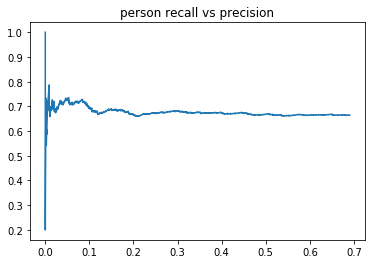

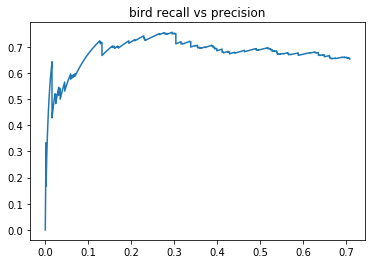

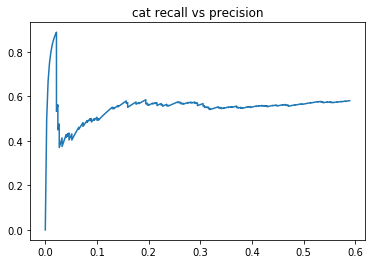

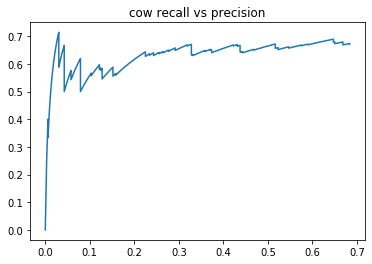

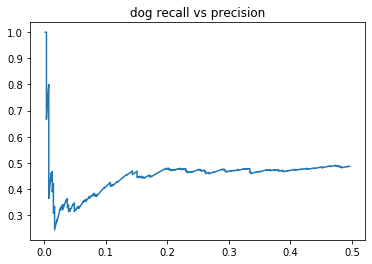

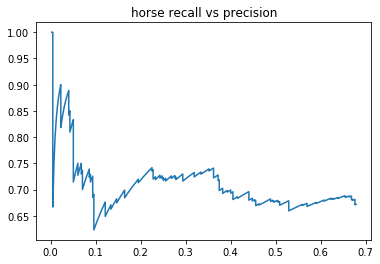

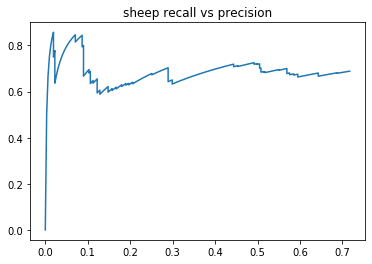

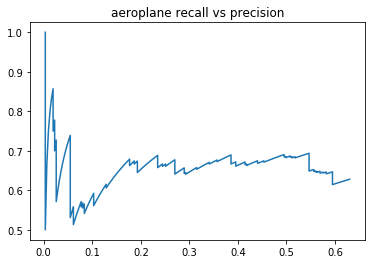

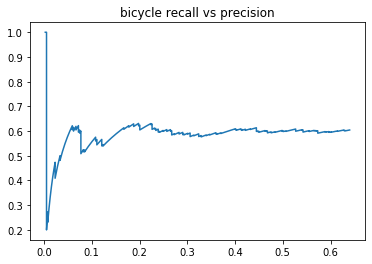

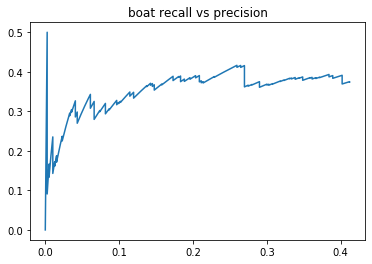

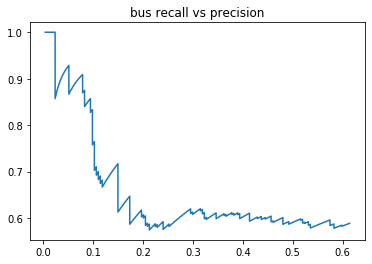

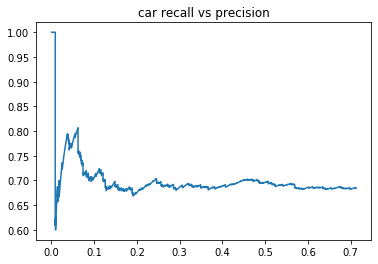

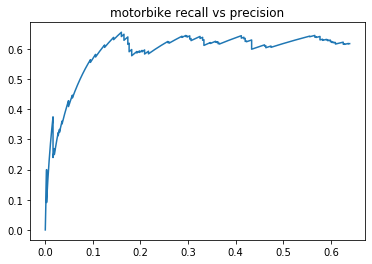

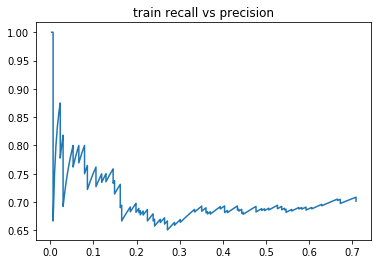

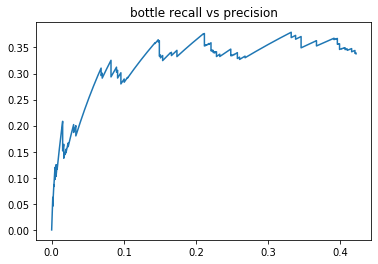

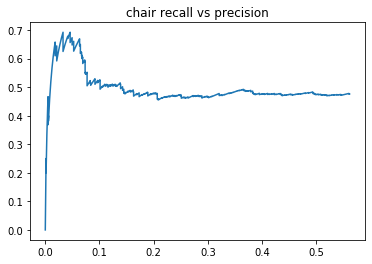

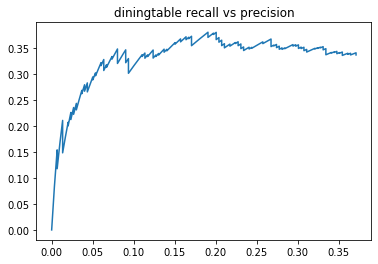

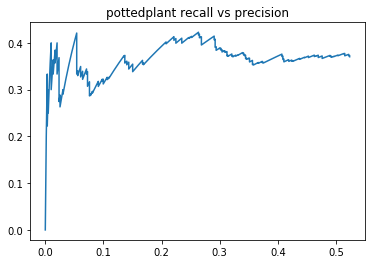

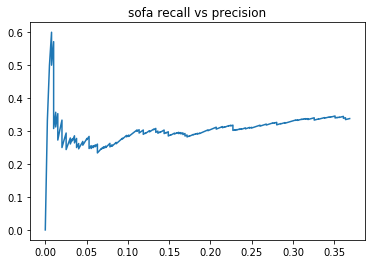

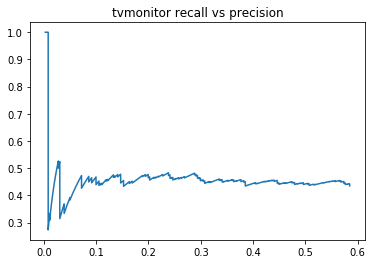

In [20]:
for key in log_dfs.keys():
    log_df=log_dfs[key]
    plt.plot(log_df.recall,log_df.precision)
    plt.title(key+' recall vs precision')
    plt.savefig(root+exp_name+'prec_recall.png')
    plt.show()

In [ ]:
np.mean(res_person.precision*res_person.recall)
res_person.loc[200:]

In [ ]:
#model.save('D:/yolo_400_exp_2.h5')

### Extra Debug

In [ ]:
GRID_W=7
GRID_H=7
BATCH_SIZE=10
cell_x = tf.to_float(tf.reshape(tf.tile(tf.range(GRID_W), [GRID_H]), (1, GRID_H, GRID_W, 1, 1)))
cell_y = tf.transpose(cell_x, (0,2,1,3,4))
cell_grid = tf.tile(tf.concat([cell_x,cell_y], -1), [BATCH_SIZE, 1, 1, 5, 1])

#pred_xy = tf.sigmoid(y_pred[..., :2]) + cell_grid
#pred_wh = tf.exp(y_pred[..., 2:4]) * np.reshape(ANCHORS, [1,1,1,BOX,2])
sess=tf.Session()
x,y,grid=sess.run([cell_x,cell_y,cell_grid])

In [ ]:
x.shape,y.shape,grid.shape

In [ ]:
z=np.concatenate([x,y],-1)
z.shape

In [ ]:
y_true=np.ones((7,7,10))
ob_mask= tf.expand_dims(y_true[..., 4], axis=-1)
sess=tf.Session()
_mask=sess.run(ob_mask)
_mask.shape,y_true[..., 4].shape

In [ ]:
import numpy as np
import tensorflow as tf
label=np.ones((7,7,15))
label[...,14]=5
true_box=np.argmax(label[...,10:],-1)

In [ ]:
wts=np.ones((10))
wts[3:7]=9
res=tf.gather(wts,true_box)
sess=tf.Session()
ret=sess.run(res)
ret

In [ ]:
ret.shape

In [ ]:
label[...,4:].shape

In [ ]:
label[...,5:].shape

In [ ]:
label[...,5:].shape

### Extra functions

In [ ]:
import csv

def read_data(dataset):
  f=open(dataset+'/label.csv')
  file=csv.reader(f,delimiter=',')
  data=[]
  i=0
  sc=416.0
  for line in file:
      dt=line
      H=dt[0]
      W=dt[1]
      xmin=(float(dt[2]))/sc
      ymin=(float(dt[3]))/sc
      xmax=(float(dt[4]))/sc
      ymax=(float(dt[5]))/sc

      output={
          'filename':dataset+'/images/'+str(i)+'.jpg',
          'height':H,
          'width':W,
          'object':[{'name':'None',
          'xmin':xmin*IMAGE_W,
          'ymin':ymin*IMAGE_H,
          'xmax':xmax*IMAGE_W,
          'ymax':ymax*IMAGE_H}]
          }

      data.append(output)
      i=i+1
  return data
